# What is this?
## This is a notebook which takes data scraped from trust pilot, and explores the data

#### Summay
- We cover basic data transformation such as tokenization and lemmatization, then general EDA on the structure of the reviews, such as words per review, broken down by 1-5 stars etc..., then we move to deeper analysis, such as bigrams, then more advanced modelling with NMF and LDA with the aim of distilling all of our reviews into topics. Next we built word clouds, and investigate reviews over time, and different trends, such as by weekday. After this we build a logistic regression model, and use ELI5 to find get insights as to how words correspond to reviews

# How to run this notebook - from scratch
### 1 - Get the data
- Run the run_new_website script, with the desired company url
- Do some initial data quality checks - e.g. number of unique reviews match (roughly) the website etc...

### 2 - Run the first 2 steps in this notebook, to clean the data
- First import the packages, then read in the data from the correct csv, then clean the data using `clean_data`

### 3 - Remove stopwords
- First run the `find_custom_stopwords` function, and use that list to define custom words to remove, for example, the name of the company
- And replace original reviews, with the clean versions (this is optional, but advised)

### 4 - Run the rest of the notebook to get the desired visualisations

In [2]:
# General imports
import pandas as pd
import numpy as np
from datetime import datetime


# libraries for visualization
from matplotlib import pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim

# For latent dirichlet allocation
import spacy
import gensim
from gensim import corpora

# For modelling and ELI5 analysis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
import eli5



In [7]:
import os
os.chdir('/Users/hectortemp/github/pytrust')

In [11]:
## Custom
# Used for plotting visualisations
from pytrust.examine.plotting_trust import *

# Used for cleaning (lemmatizing, removing punctuation, lower case etc...)
from pytrust.examine.clean_words import *


%matplotlib inline

In [12]:
# Step 1: read in data
data = pd.read_csv('data/20200705_morrisons_com_trustpilot.csv')
data.head(2)

,name,title,content,date,rating,year,month,week,day,num_stars
0,UNVERIFIED,Morrisons have been a lifeline for me…,Morrisons have been a lifeline for me since th...,2020-07-05,Excellent,2020,7,27,5,5
1,UNVERIFIED,Super Star in Store,I made a complete mess of my food to go order ...,2020-07-05,Excellent,2020,7,27,5,5


In [13]:
# Step 2: clean data
data = clean_data(data)

In [14]:
# Step 3a: How do we know which words to remove
a = [item for sublist in data['content_clean'].str.split().values for item in sublist]
pd.Series(a).value_counts().head(20)

morrison    3462
delivery    2477
service     1919
customer    1671
time        1590
item        1565
store       1337
order       1285
shopping    1270
get         1240
online      1103
would       1040
driver      1039
always       986
good         986
shop         984
one          945
food         920
staff        861
day          811
dtype: int64

In [15]:
# Step 3b: remove custom stopwords
custom_stopwords = ['dfs']
data = remove_custom_stopwords(df = data,
                        custom_stop = custom_stopwords,
                        cols = ['title_clean', 'content_clean'])
# Step 4: replace content and title with the clean versions
REPLACE = True
if REPLACE:
    data['title'] = data['title_clean']
    data['content'] = data['content_clean']
    data = data.drop(['title_clean', 'content_clean'], axis = 1)
    
# Step 5: Create quantitative features
data = create_fea(data)

# Step 6: Fix spelling - not yet implemented

In [37]:
today = datetime.today().strftime('%Y_%m_%d')
data.head()

,title,content,date,rating,year,month,week,day,num_stars,title_num_words,content_num_words,title_num_char,content_num_char,wday,is_quality,is_service,is_availability
0,morrison lifeline,morrison lifeline since beginning pandemic luc...,2020-07-05,Excellent,2020,7,27,5,5,3,41,18,285,6,False,False,False
1,super star store,made complete mess food go order noticed error...,2020-07-05,Excellent,2020,7,27,5,5,3,63,16,400,6,False,True,False
2,happy rule local morrison,happy rule local morrison aberystwyth really a...,2020-07-05,Poor,2020,7,27,5,2,5,36,26,233,6,False,False,False
3,wont ordering,see much easier get delivery morrison anywhere...,2020-07-05,Poor,2020,7,27,5,2,2,75,13,523,6,False,False,False
4,morrison staff terrible customer service,twice yr old daughter humiliated certain worke...,2020-07-04,Bad,2020,7,27,4,1,5,85,40,595,5,False,False,False


# Remove largest 5% of reviews
- Note this will skew the results, as negative ones tend to be longer, but otherwise our top few reviews may be 1000's of words, and be outliers

In [38]:
top_pct_to_drop = 0.02
data = data.sort_values('content_num_words', ascending=False).iloc[round(data.shape[0] * top_pct_to_drop):,:]

# Remove old reviews
- Do we just want to investigate say the last year?

In [39]:
print("Oldest review:", data['date'].min(), ", Newest review:", data['date'].max())

Oldest review: 2009-05-20 , Newest review: 2020-07-05


In [40]:
REMOVE_OLD = '2020-01-01' # For example, set REMOVE_OLD to '2015-01-01'
if REMOVE_OLD:
    data = data[data['date'] > REMOVE_OLD]

# What is the breakdown of 1 - 5 stars?
- No we don't need a funnel and a pie chart, but why not 

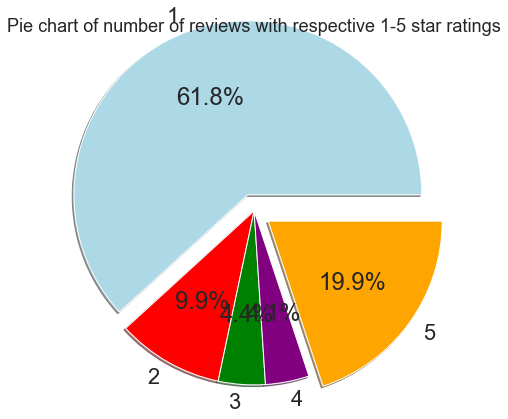

In [41]:
plot_pie_chart(df = data)

In [42]:
plot_star_funnel(data)

# Stratify reviews?
- If we have a heavily skewed dataset, we may want to take a random sample of X from each of the buckets

In [43]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

STRATIFY_REVIEWS = False
if STRATIFY_REVIEWS:
    data = stratified_sample_df(data, 'num_stars', )

In [44]:
data['num_stars'].value_counts()

1    624
5    201
2    100
3     44
4     41
Name: num_stars, dtype: int64

In [67]:
!pip install statsmodels

ImportError: Cumulative distributions are currently only implemented in statsmodels. Please install statsmodels.

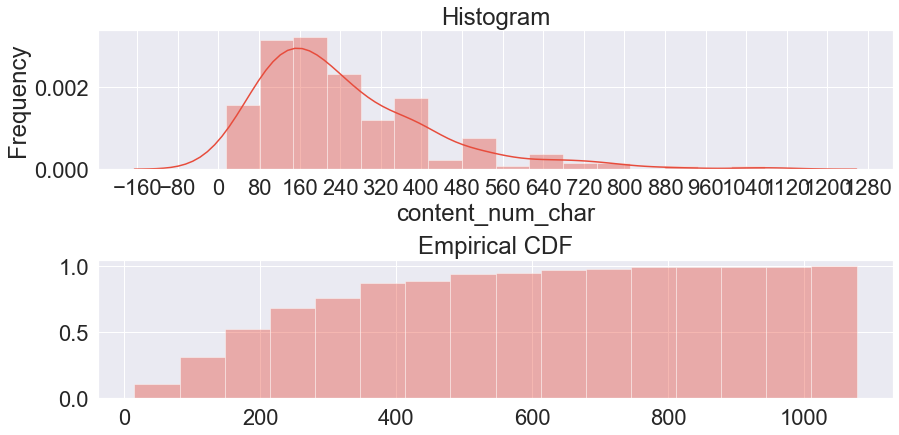

In [68]:
plot_dist3(data[data['num_stars'] == 5], 'content_num_char',
       'Characters Per "Positive review')
plot_dist3(data[data['num_stars'] == 1], 'content_num_char',
       'Characters Per "Negative review')

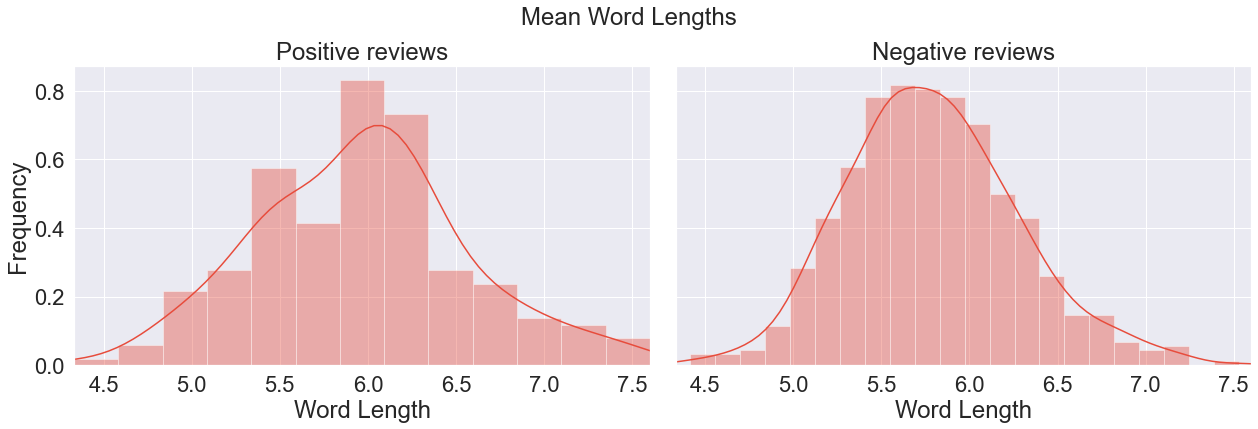

In [69]:
plot_word_len_histogram(data[data['num_stars'] == 5]['content'],
                       data[data['num_stars'] == 1]['content'])

ImportError: Cumulative distributions are currently only implemented in statsmodels. Please install statsmodels.

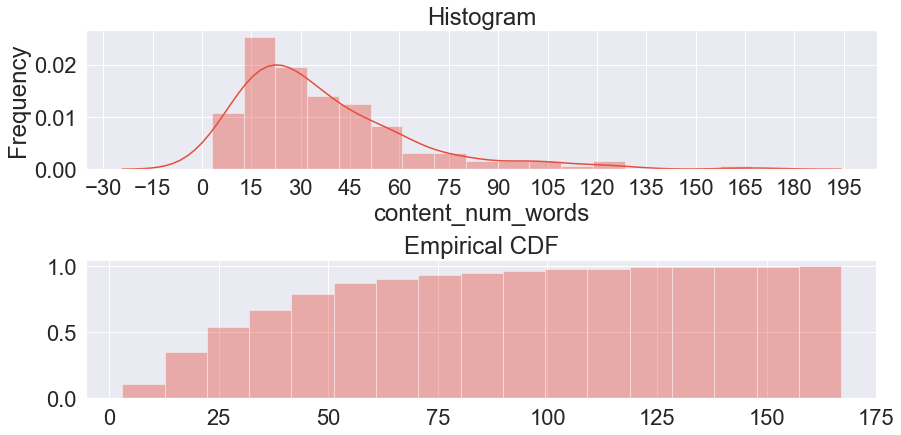

In [75]:
plot_dist3(data[data['num_stars'] == 5], 'content_num_words',
       'Words Per "Positive review')
plot_dist3(data[data['num_stars'] == 1], 'content_num_words',
       'Words Per "Negative review')

# Length of review by stars
- Dosen't always look good if our dataset is heavily skewed

In [ ]:
sns.set(font_scale = 2)
g = sns.FacetGrid(data, col='num_stars', height=4)
g.map(plt.hist,'content_num_char')
plt.subplots_adjust(top=0.8)
g.fig.suptitle(f'Size of review distribution, by number of stars')
plt.show()

# most common words
- Content is the body of the review
- Title is the title of the review

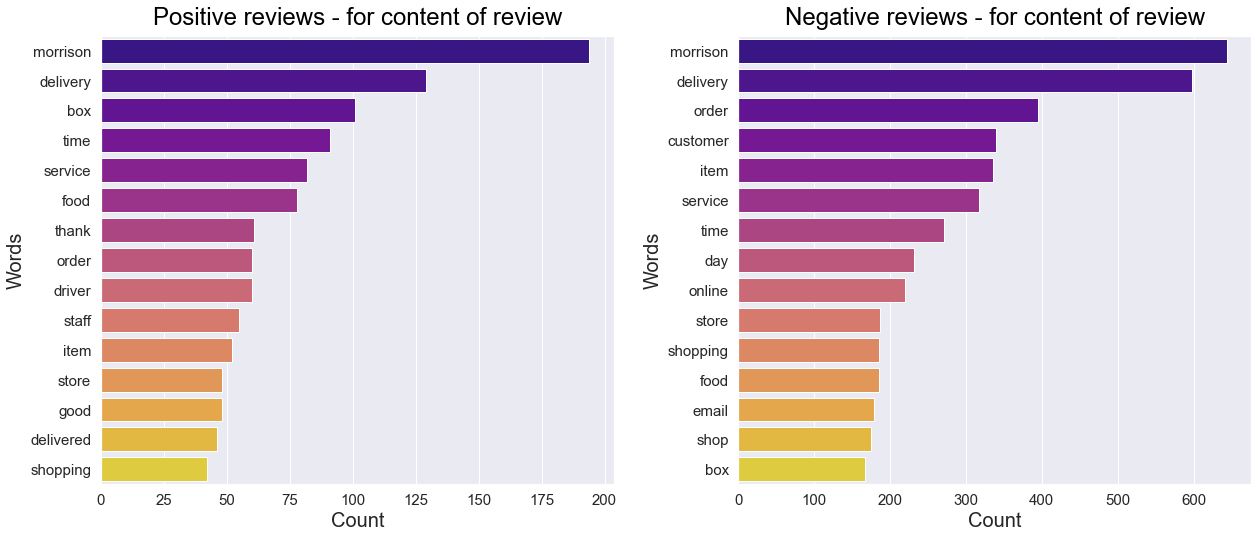

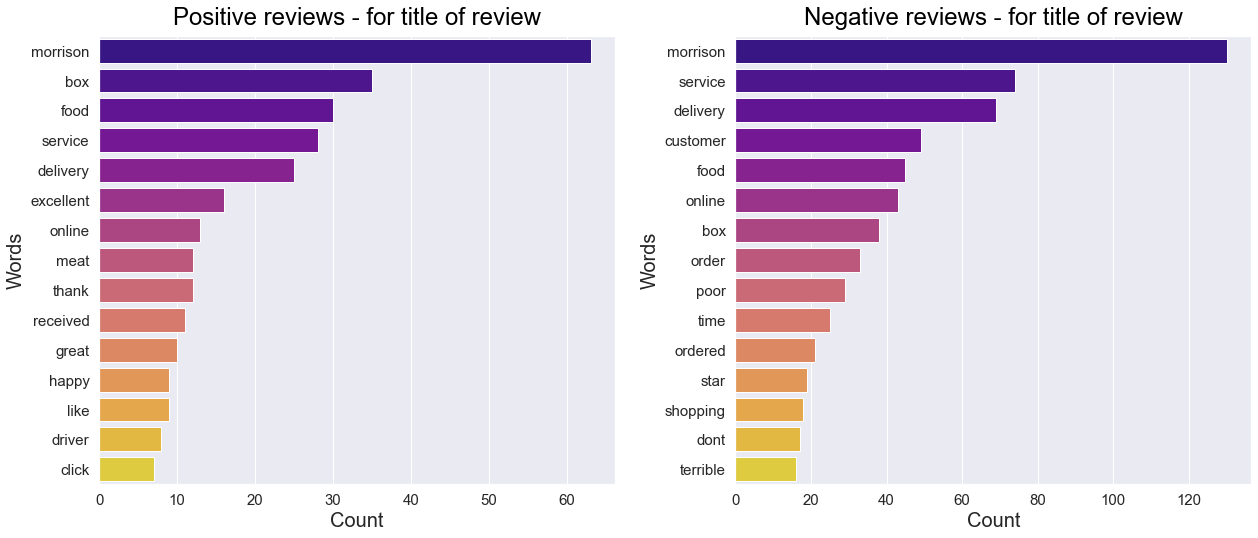

In [46]:
ngrams(df = data, n = 1, title = 'Most Common Unigrams', mx_df = 0.9, content_or_title = 'content')
ngrams(df = data, n = 1, title = 'Most Common Unigrams', mx_df = 0.9, content_or_title = 'title')

# most common bigrams

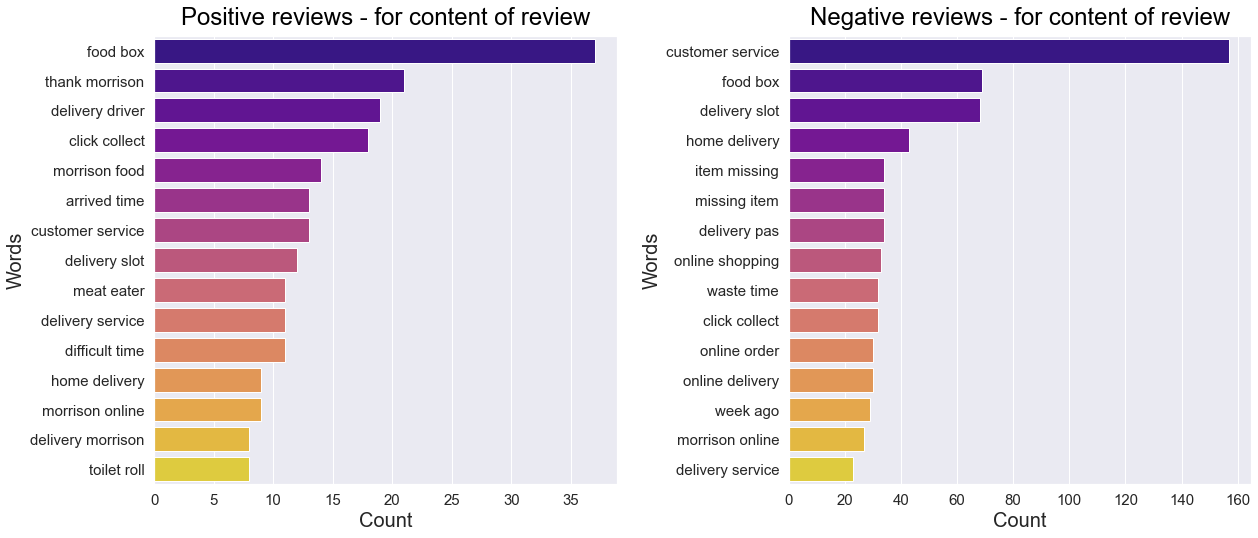

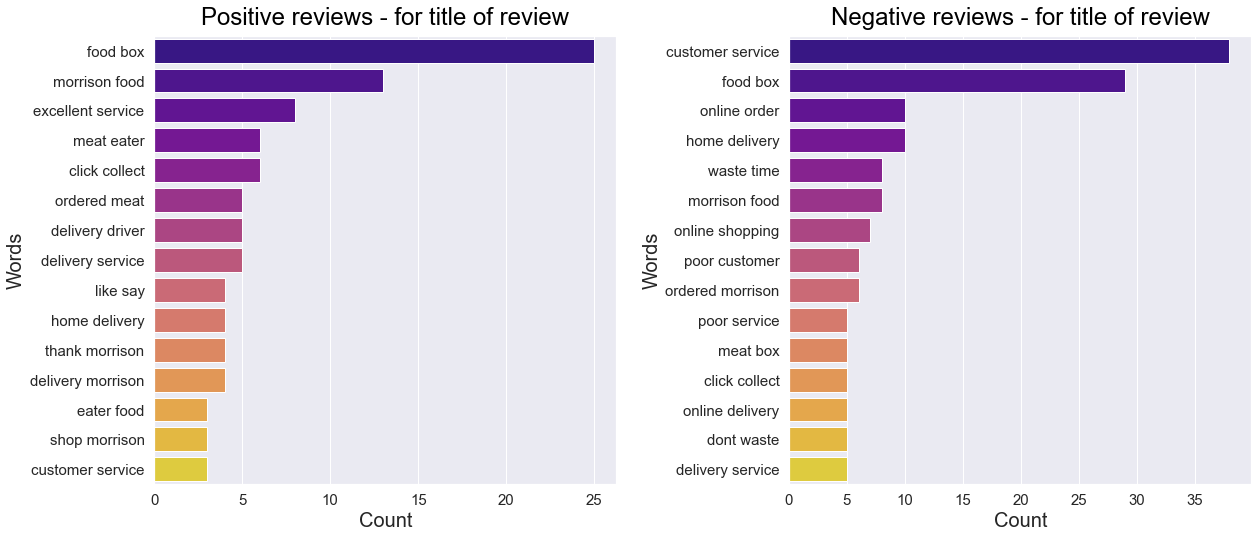

In [47]:
ngrams(df = data, n = 2, title = 'Most Common Bigrams', mx_df = 0.9, content_or_title = 'content')
ngrams(df = data, n = 2, title = 'Most Common Bigrams', mx_df = 0.9, content_or_title = 'title')

# most common trigrams

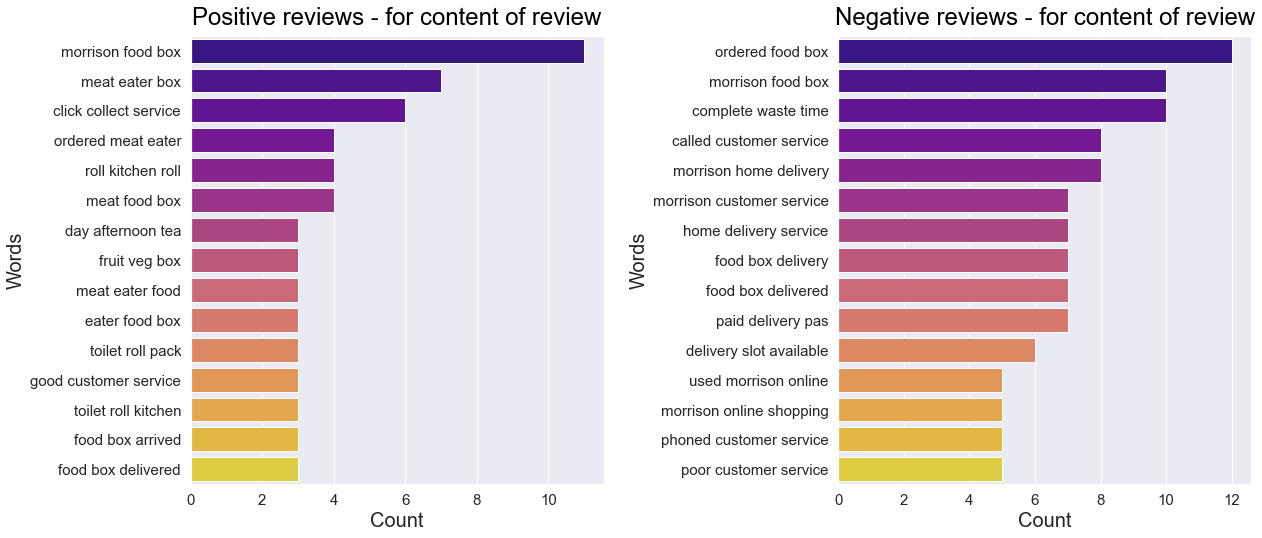

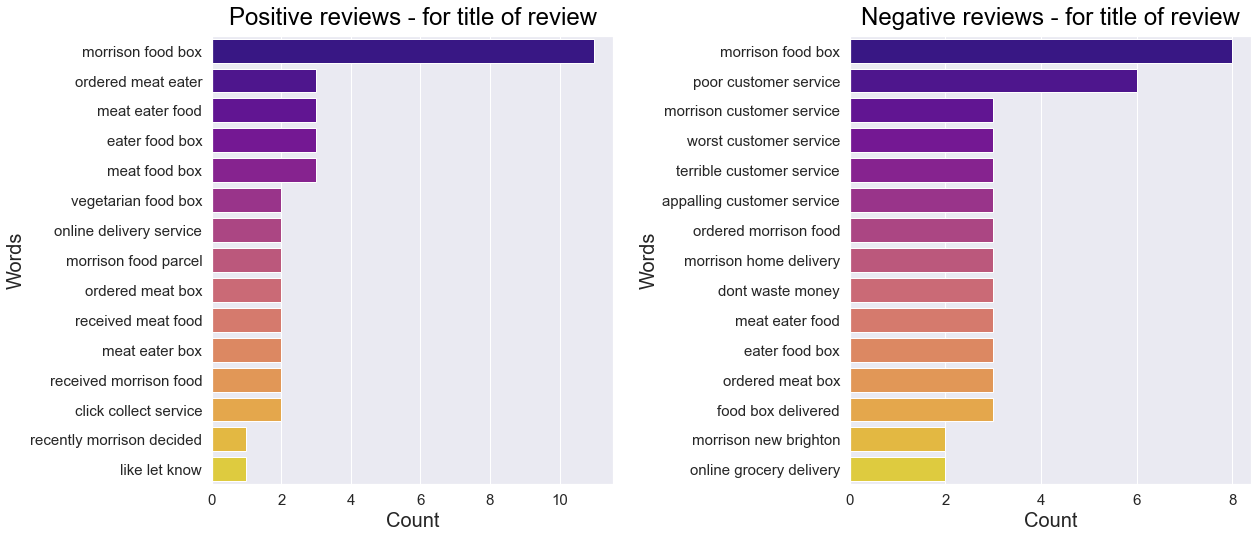

In [48]:
ngrams(df = data, n = 3, title = 'Most Common Trigrams', mx_df = 0.9, content_or_title = 'content')
ngrams(df = data, n = 3, title = 'Most Common Trigrams', mx_df = 0.9, content_or_title = 'title')

# Determining Topics
### These are potentially the most powerful outputs, if correctly tuned
#### We can do this for title or content as well
- we'll be using a method called Non-Negative Matrix Factorization (NMF) to see if we can get some defined topics out of our TF-IDF matrix, with this way TF-IDF will decrease impact of the high frequency words, so we might get more specific topics

In [62]:
print('Topics for TITLE of review')
display_topics(data[data['num_stars'] == 5]['title'], 
               no_top_words = 5,
               topic = 'Positive review topics \n',
               components = 2)
print('\n======================================\n')
print('\n======================================\n')
print('Topics for BODY of review')
display_topics(data[data['num_stars'] == 5]['content'], 
               no_top_words = 5,
               topic = 'Positive review topics \n',
               components = 10)

Topics for TITLE of review
Positive review topics 

Topic 1:
morrison delivery service food box
Topic 2:
box food morrison service delivery




Topics for BODY of review
Positive review topics 

Topic 1:
delivery driver time item online
Topic 2:
box food meat ordered received
Topic 3:
store always time would excellent
Topic 4:
well done morrison time today
Topic 5:
thank morrison say would one
Topic 6:
order online arrived time delivered
Topic 7:
shopping time got week always
Topic 8:
staff helpful friendly really morrison
Topic 9:
service good great excellent got
Topic 10:
get shop delivered morrison slot


In [63]:
print('Topics for TITLE of review')
display_topics(data[data['num_stars'] == 1]['title'], 
               no_top_words = 5,
               topic = 'Negative review topics \n',
               components = 2)
print('\n======================================\n')
print('\n======================================\n')
print('Topics for BODY of review')
display_topics(data[data['num_stars'] == 1]['content'], 
               no_top_words = 5,
               topic = 'Negative review topics \n',
               components = 10)

Topics for TITLE of review
Negative review topics 

Topic 1:
morrison food box time customer
Topic 2:
delivery service customer online poor




Topics for BODY of review
Negative review topics 

Topic 1:
delivery slot pas morrison cant
Topic 2:
box food dpd meat ordered
Topic 3:
staff morrison manager store say
Topic 4:
item missing substitution substitute stock
Topic 5:
customer service store poor use
Topic 6:
order online week cancelled ago
Topic 7:
pm late delivery due hour
Topic 8:
said would day back asked
Topic 9:
shop morrison shopping get one
Topic 10:
email phone get contact call


# Finding topics - Attempt 2 - Using `latent dirichlet allocation`
- So the above gives us great informaton on topics, with context
- Now we are just going to be looking for main topics, more similar to unigrams/bigrams/trigrams
    - see https://miningthedetails.com/blog/python/lda/GensimLDA/ for tips on training

- The printed topics, gives use insights into the actual components of the topics


- The visualisation, allows us to evaluate the term frequency inside each of the topics, to see what they are comprised of, from the reviews perspecitve, not the modelling perspective

In [64]:
DO_LDA = True

CONTENT_OR_TITLE = 'content'


reviews_split = data[CONTENT_OR_TITLE].str.split()
# creating the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(reviews_split)
# convert the list of reviews (reviews_2) into a Document Term Matrix 
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_split]

# Creating the object for LDA model using gensim library
LDA = gensim.models.LdaMulticore # .ldamodel.LdaModel

# Build LDA model - we have picked 3 main topics
# switch to sklearn.decomposition.LatentDirichletAllocation for consistency?
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=3, random_state=100,
                chunksize=1000, passes=50, workers=3)
# print out the topics that our LDA model has learned
lda_model.print_topics()

[(0,
  '0.015*"morrison" + 0.015*"staff" + 0.011*"store" + 0.010*"customer" + 0.007*"shopping" + 0.007*"one" + 0.007*"people" + 0.006*"go" + 0.006*"shop" + 0.006*"like"'),
 (1,
  '0.024*"delivery" + 0.020*"morrison" + 0.015*"order" + 0.014*"item" + 0.010*"service" + 0.010*"get" + 0.010*"time" + 0.010*"box" + 0.009*"online" + 0.008*"day"'),
 (2,
  '0.018*"morrison" + 0.007*"went" + 0.006*"store" + 0.005*"customer" + 0.005*"got" + 0.005*"service" + 0.005*"time" + 0.005*"price" + 0.004*"slot" + 0.004*"never"')]

In [65]:
import inspect
import IPython
lines = inspect.getsource()
print(lines)

TypeError: getsource() missing 1 required positional argument: 'object'

#### Try hovering over the circles on the left, or the words on the right

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from IPython.core.display import display, HTML

v = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary, plot_opts = 'ylab')
#pyLDAvis.save_html(v, 'lda.html')

from IPython.display import HTML
HTML(filename='lda.html') # Try with json

## This is the same as the above, but with the title of the review, not the content

In [ ]:
if DO_LDA:
    CONTENT_OR_TITLE = 'title'

    reviews_split = data[CONTENT_OR_TITLE].str.split()
    # creating the term dictionary of our corpus, where every unique term is assigned an index
    dictionary = corpora.Dictionary(reviews_split)
    # convert the list of reviews (reviews_2) into a Document Term Matrix 
    doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_split]

    # Creating the object for LDA model using gensim library
    LDA = gensim.models.LdaMulticore

    # Build LDA model - we have picked 3 main topics
    lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=3, random_state=100,
                    chunksize=1000, passes=50, workers=3)
    # print out the topics that our LDA model has learned
    lda_model.print_topics()

    # Visualize the topics
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
    vis

- From the above, we can use this to filter reviews into larger buckets, which gives us the breakdown of the pareto

# Word cloud

In [ ]:
plot_wordcloud(df = data[data['num_stars'] == 5]['content'],
               max_words=200, max_font_size=100, 
               title = 'Most common words of POSITIVE reviews',
               title_size=50, image = 'basket.png',
              more_stopwords = {'store', 'order'})

In [ ]:
plot_wordcloud(df = data[data['num_stars'] == 1]['content'],
               max_words=200, max_font_size=100, 
               title = 'Most common words of NEGATIVE reviews',
               title_size=50, image = 'basket.png',
              more_stopwords = {'store', 'order', 'one', 'morrisons'})

# Add year filter
- Why are we getting spikes on certain days?
    - We can investigate previous drops, and see the causes, then compare to current drops
- Maybe scale count to 1-5? (or 0-5)

In [ ]:
time_series_slider(df = data, window = 30, add_count = False, add_var = True, add_kurt = False)

# Ratings by weekday etc...
- turn this to nice plots and functions

In [ ]:
trend_barplots(df = data,
               mean_or_count = 'count',
               plots = ['wday', 'day', 'week', 'month', 'year'])

# Now let's group our reviews into categories
- Then pareto the main complaints by stars? Stack bar chart

- So for each review, we want a primary, and maybe a secondary reason

- Let's use the categories previously used,


    - Quality - Material
    - Quality - Durability
    - Quality - Finishing
    - Quality - Uncomfortable


    - Delivery - Order Delayed
    - Delivery - Wrong Address
    - Delivery - Damage
    - Delivery - Charges/Trips


    - Customer Service - Unresponsive
    - Customer Service - Not Helpful
    - Customer Service - Guarantee
    - Customer Service - Order Updates
    - Customer Service - Price Change
    - Customer Service - Refunds/Finance
    
    
    - Availability - Out of Stock
    - Availability - Outdated


    - Other


#### Current analysis is very basic, this needs more work
- So the main categories are quality, delivery, customer service, availability and other

In [ ]:
data['num_stars'].mean()

In [ ]:
data['is_quality'] = ['quality' in i for i in data['content'].str.split()]
data['is_service'] = ['service' in i for i in data['content'].str.split()]
data['is_availability'] = ['availability' in i for i in data['content'].str.split()]

In [ ]:
grp = data.groupby(['is_quality'])['num_stars']
print('===COUNT===')
print(grp.count())
print('===MEAN===')
print(grp.mean())

In [ ]:
grp = data.groupby(['is_service'])['num_stars']
print('===COUNT===')
print(grp.count())
print('===MEAN===')
print(grp.mean())

In [52]:
grp = data.groupby(['is_availability'])['num_stars']
print('===COUNT===')
print(grp.count())
print('===MEAN===')
print(grp.mean())

===COUNT===
is_availability
False    999
True      11
Name: num_stars, dtype: int64
===MEAN===
is_availability
False    2.109109
True     1.636364
Name: num_stars, dtype: float64


# Now let's do some predictive modelling
- The aim of this is to find which words are the best predictors, for a given score, which will help inform what is wrong with a company
- https://www.kaggle.com/nicapotato/guided-numeric-and-text-exploration-e-commerce

- So our X data will be content
- Our y data will be num_stars
    - Where 1 and 2 stars = negative, 
    - 3 will be dropped (for now)
    - 4 and 5 will be positive

In [53]:
# Prep data
data_for_reg = data[data['num_stars'] != 3].copy()
data_for_reg.loc[:,'target'] = -9999
data_for_reg.loc[data_for_reg['num_stars'] < 3, 'target'] = 0 # 0 negative
data_for_reg.loc[data_for_reg['num_stars'] > 3, 'target'] = 1 # 1 positive

X_full = data_for_reg['content']
y_full = data_for_reg['target']

In [54]:
vect = TfidfVectorizer()
X = vect.fit_transform(X_full)

In [55]:
y = y_full

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20, random_state=23, stratify=y)

In [56]:
X_train.shape, X_valid.shape

((772, 5869), (194, 5869))

In [57]:

model = LogisticRegression()
model.fit(X_train, y_train)
print("Train Set Accuracy: {}".format(metrics.accuracy_score(model.predict(X_train), y_train)))
print("Train Set ROC: {}\n".format(metrics.roc_auc_score(model.predict(X_train), y_train)))

print("Validation Set Accuracy: {}".format(metrics.accuracy_score(model.predict(X_valid), y_valid)))
print("Validation Set ROC: {}".format(metrics.roc_auc_score(model.predict(X_valid), y_valid)))

Train Set Accuracy: 0.905440414507772
Train Set ROC: 0.9440184049079754

Validation Set Accuracy: 0.8041237113402062
Validation Set ROC: 0.8961748633879781


In [58]:
print(metrics.classification_report(model.predict(X_valid), y_valid))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88       183
           1       0.22      1.00      0.37        11

    accuracy                           0.80       194
   macro avg       0.61      0.90      0.63       194
weighted avg       0.96      0.80      0.85       194



# Plot the confustion matrix
- These matrices are for the validation data
    - That is data that the model is seeing for the first time
    - So we only give the model the review, not the rating
        - Then predict the rating with the model and the below matrix gives us the split on true positives, true negatives, false positives and false negatives
            - This speaks to how "good" or "bad" our model is

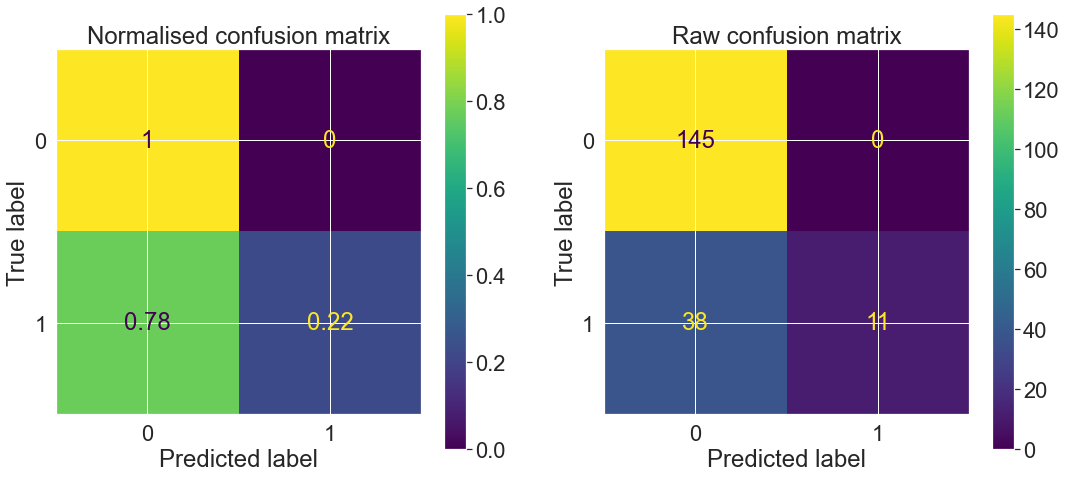

In [59]:
# Confusion Matrix\
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()
sns.set(font_scale=2.0)
for norm, j in zip(['true', None], axes):
    plot_confusion_matrix(model, X_valid, y_valid, normalize = norm, ax = j)
axes[0].set_title(f'Normalised confusion matrix', fontsize = 24)
axes[1].set_title(f'Raw confusion matrix', fontsize = 24)
plt.show()

# Word importance using ELI5
- Stand for "Explain Like I'm 5"
- Used to debug machine learning classifiers and explain their predictions

In [60]:
target_names = [0, 1]
eli5.show_weights(model, vec=vect, top=100,
                  target_names=target_names)

Weight?,Feature
+2.725,thank
+2.249,well
+2.030,helpful
+1.959,driver
+1.958,friendly
+1.924,great
+1.849,excellent
+1.271,done
+1.176,polite
+1.100,happy


# Now we can run through each row, and find out what the model is doing
- These scores are the contribution of each word to the desired result
    - That is different from above

In [61]:
for iteration in range(5):
    samp = random.randint(1,data.shape[0])
    print("Real Label: {}, on {}".format(data['rating'].iloc[samp], data['date'].iloc[samp]))
    display(eli5.show_prediction(model,data["content"].iloc[samp], vec=vect,
                         target_names=target_names))

Real Label: Bad, on 2020-06-28


Real Label: Bad, on 2020-04-26


Real Label: Bad, on 2020-03-28


Real Label: Excellent, on 2020-04-20


Real Label: Bad, on 2020-01-11


# Now let's used a more powerful model, and compare the results
- Let's start with LGBM

# Now let's build / use a sentiment model, and see how this corresponds to the stars